In [30]:
# Install dependencies
!pip install seaborn
!pip install scikit-learn
!pip install matplotlib
!pip install singlestoredb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
from prettytable import PrettyTable
import singlestoredb as s2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [31]:
# Setup database by uploading winequality-red.csv to SingleStore. Then, use SingleStore pipeline to add the csv as a table
#USE wine;
#CREATE TABLE wine.`winequality-red` (
	#`fixed acidity` double NULL,
	#`volatile acidity` double NULL,
	#`citric acid` double NULL,
	#`residual sugar` double NULL,
	#`chlorides` double NULL,
	#`free sulfur dioxide` double NULL,
	#`total sulfur dioxide` double NULL,
	#`density` double NULL,
	#`pH` double NULL,
	#`sulphates` double NULL,
	#`alcohol` double NULL,
	#`quality` bigint(20) NULL,
	 #SHARD KEY ()
#);

In [32]:
#USE wine;
#CREATE PIPELINE wine.`winequality-red`
#AS LOAD DATA STAGE 'winequality-red.csv'
#BATCH_INTERVAL 2500
#DISABLE OUT_OF_ORDER OPTIMIZATION
#DISABLE OFFSETS METADATA GC
#SKIP DUPLICATE KEY ERRORS -- SKIP ALL ERRORS can be used to skip all errors that can be tracked through "Monitor the pipeline for errors"
#INTO TABLE `winequality-red`
#FIELDS TERMINATED BY ',' ENCLOSED BY '"' ESCAPED BY '\\' 
#LINES TERMINATED BY '\n' STARTING BY '' 
#IGNORE 1 LINES
#FORMAT CSV
#(
	#`winequality-red`.`fixed acidity`,
	#`winequality-red`.`volatile acidity`,
	#`winequality-red`.`citric acid`,
	#`winequality-red`.`residual sugar`,
	#`winequality-red`.`chlorides`,
	#`winequality-red`.`free sulfur dioxide`,
	#`winequality-red`.`total sulfur dioxide`,
	#`winequality-red`.`density`,
	#`winequality-red`.`pH`,
	#`winequality-red`.`sulphates`,
	#`winequality-red`.`alcohol`,
	#`winequality-red`.`quality`
#);

In [33]:
#START PIPELINE shop.`winequality-red`;

In [34]:
# Connect notebook to created table 'winequality-red'
from sqlalchemy import *

db_connection = create_engine(connection_url)

In [35]:
wine_data = pd.read_sql_query("SELECT * FROM `winequality-red`", db_connection)

In [36]:
wine_data.shape

(1599, 12)

In [37]:
wine_data.columns = wine_data.columns.str.replace(' ', '_')

In [38]:
# Distribution of qualities
wine_data['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

In [39]:
# Correlations between variables and quality
correlations = wine_data.corr()['quality'].sort_values(ascending=False)
print(correlations)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric_acid             0.226373
fixed_acidity           0.124052
residual_sugar          0.013732
free_sulfur_dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total_sulfur_dioxide   -0.185100
volatile_acidity       -0.390558
Name: quality, dtype: float64


<Axes: >

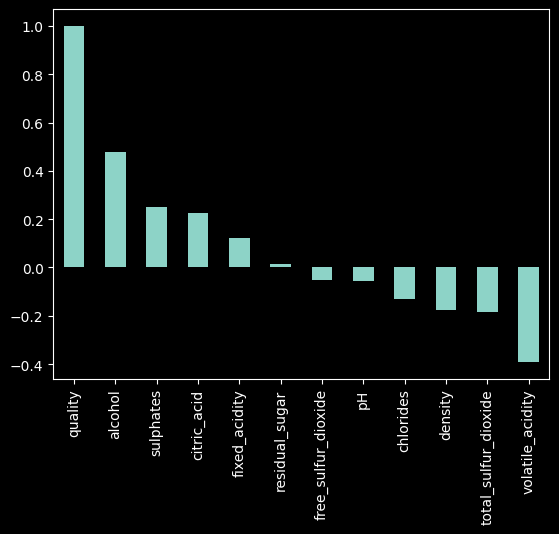

In [40]:
# Visualize correlation
correlations.plot(kind='bar')

In [41]:
# Keep only the columns with high correlation with quality (greater than +-0.2), easier for amateurs to understand the winemaking process
correlations[abs(correlations) > 0.2]

quality             1.000000
alcohol             0.476166
sulphates           0.251397
citric_acid         0.226373
volatile_acidity   -0.390558
Name: quality, dtype: float64

In [42]:
# Edit dataset based on these findings, remove variables that do not affect quality that much
values = wine_data.loc[:,['alcohol','sulphates','citric_acid','volatile_acidity']]
labels = wine_data.iloc[:,11]

In [43]:
# Split data into train and test sets
# Change test size to test accuracy
x_train, x_test, y_train, y_test = train_test_split(values, labels, test_size=0.2, random_state=random.randint(1, 1000))

In [44]:
# Create table to store model coefficients and statistics, change to SQL language
#CREATE TABLE IF NOT EXISTS training_coefficients (
   #alcohol FLOAT,
    #sulfates FLOAT,
    #citric_acid FLOAT,
    #volatile_acidity FLOAT,
    #intercept FLOAT,
    #accuracy FLOAT,
    #train_method VARCHAR(20)
#);

In [45]:
# Linear regression model
lr = LinearRegression()
lr.fit(x_train, y_train)
lr.score(x_train, y_train)
lr_pred = lr.predict(x_test)
lr_pred = np.round(lr_pred)
accuracy_score(y_test, lr_pred)

0.59375

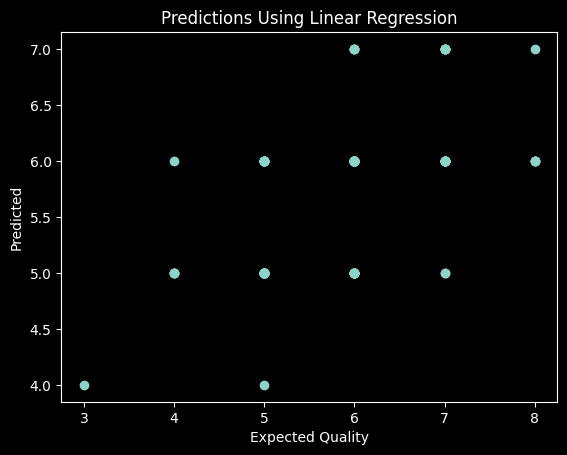

In [46]:
plt.scatter(y_test,lr_pred)
plt.title("Predictions Using Linear Regression")
plt.xlabel("Expected Quality")
plt.ylabel("Predicted")
plt.show()

In [47]:
# Model parameters
print(lr.coef_)
print(lr.intercept_)

[ 0.30748144  0.62391624 -0.13098274 -1.28449522]
2.719797557558395


In [48]:
# Order of inputs: alcohol, sulfates, citric acid, volatile acidity
# Manual test: (9.4, 0.56, 0.00, 0.70, quality: 5)
coeff = lr.coef_
y_int = lr.intercept_
prediction = coeff[0] * 9.4 + coeff[1] * 0.56 + coeff[2] * 0.00 + coeff[3] * 0.70 + y_int
int(prediction)

5

In [49]:
# Logistic Regression model
logr = LogisticRegression()
logr.fit(x_train, y_train)
logr.score(x_train, y_train)
logr_pred = logr.predict(x_test)
logr_pred = np.round(logr_pred)
accuracy_score(y_test, logr_pred)

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.578125

In [50]:
# KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
knn.score(x_train, y_train)
knn_pred = knn.predict(x_test)
knn_pred = np.round(knn_pred)
accuracy_score(y_test, knn_pred)

0.603125

In [51]:
# Decision tree model
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)
dtree.score(x_train, y_train)
dtree_pred = dtree.predict(x_test)
dtree_pred = np.round(dtree_pred)
accuracy_score(y_test, dtree_pred)

0.628125

In [52]:
# 1-off accuracy test because the predictiction is being rounded, 
# gives leeway if prediction was rounded up or down
def one_accuracy(predicted, true):
	i = 0
	for x,y in zip(predicted,true):
		if(abs(x-y)==1):
			predicted[i] = y
		i = i + 1

In [53]:
# Precision, recall, f1 is combined precision and recall
warnings.filterwarnings('ignore')
ptbl = PrettyTable()
ptbl.field_names = ["Model", "Precision", "Recall", "F1Score"]
ptbl.add_row(["Lin Reg", precision_score(y_test, lr_pred, average = 'weighted'),
           recall_score(y_test, lr_pred, average = 'weighted'), f1_score(y_test, lr_pred, average = 'weighted')])
one_accuracy(lr_pred, y_test)
ptbl.add_row(["Log Reg", precision_score(y_test, logr_pred, average = 'weighted'),
           recall_score(y_test, logr_pred, average = 'weighted'), f1_score(y_test, logr_pred, average = 'weighted')])
one_accuracy(logr_pred, y_test)
ptbl.add_row(["KNN", precision_score(y_test, knn_pred, average = 'weighted'),
           recall_score(y_test, knn_pred, average = 'weighted'), f1_score(y_test, knn_pred, average = 'weighted')])
one_accuracy(knn_pred, y_test)
ptbl.add_row(["D Tree", precision_score(y_test, dtree_pred, average = 'weighted'),
           recall_score(y_test, dtree_pred, average = 'weighted'), f1_score(y_test, dtree_pred, average = 'weighted')])
one_accuracy(dtree_pred, y_test)
lr_acc = precision_score(y_test, lr_pred, average = 'weighted')
logr_acc = precision_score(y_test, logr_pred, average = 'weighted')
knn_acc = precision_score(y_test, knn_pred, average = 'weighted')
dtree_acc = precision_score(y_test, dtree_pred, average = 'weighted')
ptbl.add_row(["Lin Reg w/ 1-off", lr_acc,
           recall_score(y_test, lr_pred, average = 'weighted'), f1_score(y_test, lr_pred, average = 'weighted')])
ptbl.add_row(["Log Reg w/ 1-off", logr_acc,
           recall_score(y_test, logr_pred, average = 'weighted'), f1_score(y_test, logr_pred, average = 'weighted')])
ptbl.add_row(["KNN w/ 1-off", knn_acc,
           recall_score(y_test, knn_pred, average = 'weighted'), f1_score(y_test, knn_pred, average = 'weighted')])
ptbl.add_row(["D Tree w/ 1-off", dtree_acc,
           recall_score(y_test, dtree_pred, average = 'weighted'), f1_score(y_test, dtree_pred, average = 'weighted')])
print(ptbl)

+------------------+--------------------+----------+--------------------+
|      Model       |     Precision      |  Recall  |      F1Score       |
+------------------+--------------------+----------+--------------------+
|     Lin Reg      | 0.5810805722891567 | 0.59375  | 0.5663948867896236 |
|     Log Reg      | 0.5549021340463897 | 0.578125 | 0.5373760857534708 |
|       KNN        | 0.595593105763647  | 0.603125 | 0.5948721893583978 |
|      D Tree      | 0.6385183960523888 | 0.628125 | 0.6313222847732843 |
| Lin Reg w/ 1-off | 0.9787920411220042 | 0.978125 | 0.9738833218885994 |
| Log Reg w/ 1-off | 0.9696894120330615 | 0.971875 | 0.9660494783819077 |
|   KNN w/ 1-off   | 0.9425567581648966 | 0.928125 | 0.9297459296218487 |
| D Tree w/ 1-off  | 0.9481333757705709 | 0.934375 | 0.9398161142297068 |
+------------------+--------------------+----------+--------------------+


In [54]:
# Linear regression has most accurate predictions, add lin reg model coefficients to the table

conn = s2.connect(host='svc-0c9d0256-1694-4ead-b198-4e52bfceafad-dml.aws-london-1.svc.singlestore.com', port='3306', user='admin', password='Simon123', database='wine')

coeff_list = (coeff[0], coeff[1], coeff[2], coeff[3], y_int, lr_acc, 'Linear Reg')

insert_query = "INSERT INTO training_coefficients (alcohol, sulfates, citric_acid, volatile_acidity, intercept, accuracy, train_method) VALUES (%s, %s, %s, %s, %s, %s, %s)"
with conn:
    conn.autocommit(True)
    with conn.cursor() as cur:
        cur.execute(insert_query, coeff_list)

In [55]:
model_data = pd.read_sql_query("SELECT * FROM `training_coefficients`", db_connection)
model_data

,alcohol,sulfates,citric_acid,volatile_acidity,intercept,accuracy,train_method
0,0.306035,0.699891,-0.078278,-1.27901,2.68140,0.967143,Linear Reg
1,0.327445,0.784332,-0.102319,-1.24023,2.40339,0.948577,Linear Reg
2,0.308544,0.690117,-0.165263,-1.40046,2.77300,0.957364,Linear Reg
3,0.307800,0.759599,-0.027238,-1.28357,2.61466,0.969078,Linear Reg
4,0.305379,0.711872,-0.105264,-1.29868,2.69102,0.969501,Linear Reg
5,0.302274,0.747743,-0.079876,-1.26316,2.68822,0.942732,Linear Reg
6,0.306035,0.699891,-0.078278,-1.27901,2.68140,0.967143,Linear Reg
7,0.307481,0.623916,-0.130983,-1.28450,2.71980,0.978792,Linear Reg
